In [40]:
import pandas as pd
import numpy as np

# Data
df_partition = pd.read_csv("average_network_partition.csv", index_col=[0])
df_individuals = pd.read_csv('../networks/data/global_before_1700.csv', index_col=[0])

df_partition['community'] = df_partition['community'].astype(int)
mapping = {0:'Human Domain', 1:'Natural Domain', 2:'Abstract Domain'}
df_partition['domain'] = df_partition['community'].apply(lambda x: mapping.get(x))

df_individuals['meta_occupation']  = df_individuals['meta_occupation'].apply(lambda x: x.split(' |'))
df_individuals = df_individuals.explode('meta_occupation')
df_individuals = df_individuals.rename(columns={'meta_occupation':'node'})
df_individuals = pd.merge(df_individuals, df_partition, on = 'node')
df_individuals = df_individuals.drop_duplicates(['wikidata_id', 'domain'], keep='first')

df_individuals['date'] = df_individuals['birthyear'].apply(lambda x : np.round(np.array(x) / 100) * 100
                                                           
)

df_auto = df_individuals[['wikidata_id', 'domain', 'date']].copy()
df_auto = df_auto.groupby(['domain', 'date'])['wikidata_id'].count().reset_index()

# Calculate the total sum of wikidata_id for each date
date_totals = df_auto.groupby('date')['wikidata_id'].transform('sum')

# Compute the percentage of each domain for every date
df_auto['percent'] = (df_auto['wikidata_id'] / date_totals) * 100
#df_auto = df_auto[df_auto['date']>=-500]
df_auto

,domain,date,wikidata_id,percent
0,Abstract Domain,-800.0,1,100.000000
1,Abstract Domain,-600.0,5,25.000000
2,Abstract Domain,-500.0,7,11.864407
3,Abstract Domain,-400.0,12,12.244898
4,Abstract Domain,-300.0,11,17.460317
...,...,...,...,...
69,Natural Domain,1300.0,24,6.539510
70,Natural Domain,1400.0,45,6.493506
71,Natural Domain,1500.0,307,11.188047
72,Natural Domain,1600.0,671,13.849329


<AxesSubplot: xlabel='date'>

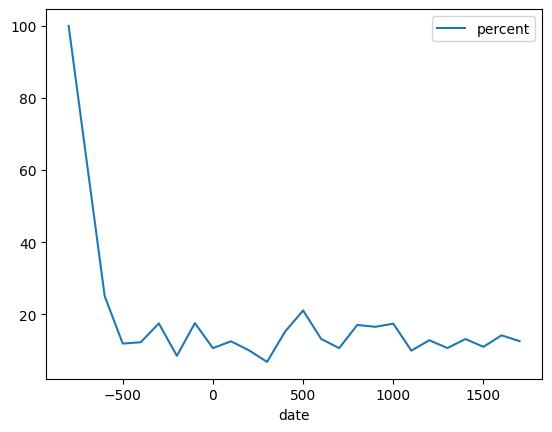

In [41]:
df_auto[df_auto['domain']=='Abstract Domain'].plot(x = 'date', y = 'percent')

In [42]:
df_auto

,domain,date,wikidata_id,percent
0,Abstract Domain,-800.0,1,100.000000
1,Abstract Domain,-600.0,5,25.000000
2,Abstract Domain,-500.0,7,11.864407
3,Abstract Domain,-400.0,12,12.244898
4,Abstract Domain,-300.0,11,17.460317
...,...,...,...,...
69,Natural Domain,1300.0,24,6.539510
70,Natural Domain,1400.0,45,6.493506
71,Natural Domain,1500.0,307,11.188047
72,Natural Domain,1600.0,671,13.849329


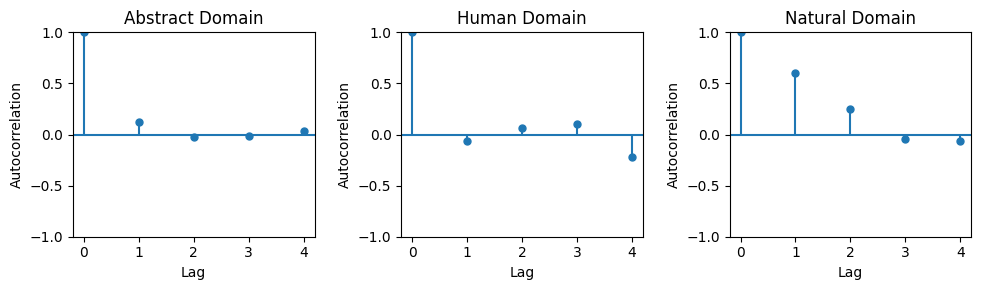

In [43]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf


# Group the data by 'domain'
grouped_data = df_auto.groupby('domain')

fig, axs = plt.subplots(1, 3, figsize=(10, 3))

# Iterate over each domain and compute autocorrelation with confidence intervals
for i, (domain, group) in enumerate(grouped_data):
    #autocorr, conf_int = acf(group['percent'], nlags=len(group)-1, fft=True, alpha=0.05)
    plot_acf(group['percent'], lags = 4, ax=axs[i], alpha=None, title=f'{domain}')
    axs[i].set_xlabel('Lag')
    axs[i].set_ylabel('Autocorrelation')

plt.tight_layout()
plt.show()

In [44]:
list(df_partition[df_partition['domain']=='Natural Domain']['node'])

['geographer',
 'zoologist',
 'botanist',
 'anatomist',
 'chemist',
 'pharmacologist',
 'geologist',
 'paleontologist',
 'art theorist']

## Old code

In [45]:
import sqlite3
import pandas as pd
import numpy as np
import os
import polars as pl

import random
random.seed(42)

import sys

sys.path.append('../')
sys.path.append('../src')
from dotenv import load_dotenv

import plotly.express as px

In [46]:
# Load the environment variables from the .env file
dotenv_path = os.path.join('../', '.env')
load_dotenv(dotenv_path)

True

In [47]:
from functions.env import DB_SCIENCE_PATH

conn = sqlite3.connect(DB_SCIENCE_PATH)
conn_full_db = sqlite3.connect(os.getenv("FULL_DB_PATH"))

In [48]:
columns_to_keep = [
        "re_arabic_world",
        "re_central_europe",
        "re_chinese_world",
        "re_eastern_europe",
        "re_france",
        "re_german_world",
        "re_greek_world",
        "re_indian_world",
        "re_italy",
        "re_japan",
        "re_low_countries",
        "re_nordic_countries",
        "re_persian_world",
        "re_slav_world",
        "re_spain",
        "re_united_kingdom",
    ]


In [49]:
df_occupation = pd.read_sql("SELECT * FROM individual_id_cleaned_occupations", conn)


In [50]:

df_ind_regions = pd.read_sql_query(
        "SELECT * FROM individuals_regions", conn_full_db
    )
df_ind_regions = df_ind_regions.rename(
        columns={"individual_wikidata_id": "wikidata_id"}
    )


df_indi = pd.merge(df_occupation, df_ind_regions, on = 'wikidata_id', how = 'left')
df_indi = df_indi[['wikidata_id', 'region_code']].drop_duplicates()

In [51]:
len(set(df_indi.wikidata_id))

22120

In [52]:
data_all = pd.read_sql_query(
        "SELECT * FROM temporal_data", conn
    )
data_all = data_all[data_all['wikidata_id'].isin(list(set(data_all['wikidata_id'])))]

In [53]:
len(set(data_all.wikidata_id))

21801

In [54]:
temporal_resolution ='fifty'

data = data_all.groupby(['region_code', temporal_resolution, 'interest'])['wikidata_id'].count().reset_index()
data = data[data[temporal_resolution]<=1800]
#data = data[data['region_code'].isin(columns_to_keep)]

In [55]:
re_asia = ['re_chinese_world', 're_japan', 're_korea', 're_indian_world']

In [56]:
# https://www.alpharithms.com/autocorrelation-time-series-python-432909/

# Import packages
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

In [57]:
#data_corr = data_corr.groupby([temporal_resolution, 'interest'])['wikidata_id'].count().reset_index()

IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

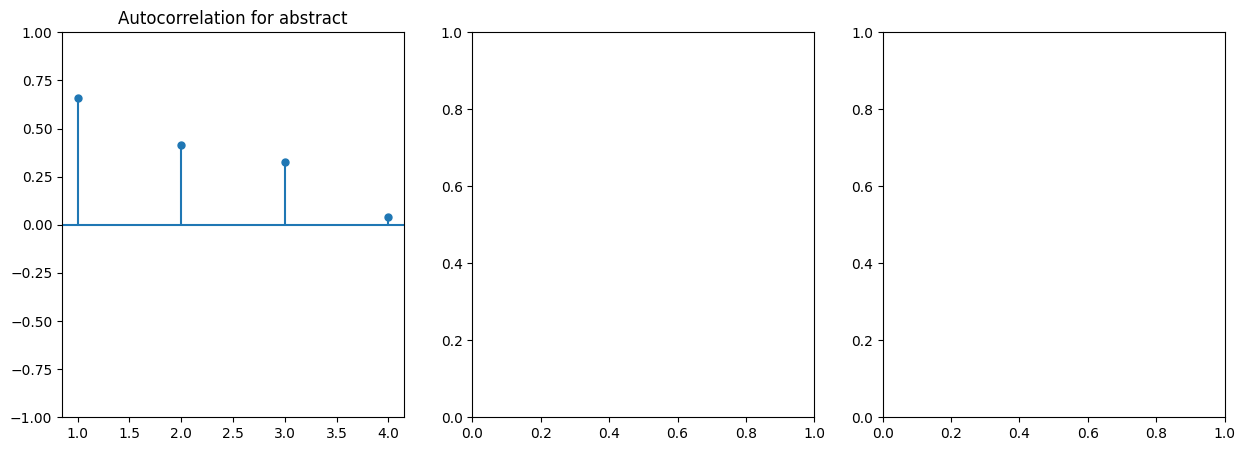

In [58]:
region_code = 're_western_europe'

# For asia
data_corr = data[data['region_code'].isin(re_asia)]
#data_corr = data_corr.groupby([temporal_resolution, 'interest'])['wikidata_id'].count().reset_index()
#data_corr = data[data['region_code']==region_code]
data_group = data_corr.groupby(['fifty', 'interest'])['wikidata_id'].sum().reset_index()
data_sum = data_group.groupby('fifty')['wikidata_id'].sum().reset_index()
data_sum.columns = ['fifty', 'total']
data_sum = data_sum[data_sum['total']>=5]
df_final = pd.merge(data_group, data_sum, on = 'fifty')
df_final['percent'] = df_final['wikidata_id']/df_final['total']
df_final = df_final[df_final['fifty']<1850]

# Create subplots for each variable
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Loop through each variable and plot its autocorrelation
for i, variable in enumerate(['abstract', 'nature', 'humans']):
    ax = axes[i]
    variable_data = df_final[df_final['interest'] == variable]['wikidata_id']
    
    # Plot the autocorrelation
    plot_acf(variable_data, lags=4, ax=ax, title=f'Autocorrelation for {variable}', zero=False)
    
    lags_to_plot = [50, 100, 150, 200]

    ax.set_xlabel('Lags (every 50 years)', fontsize=12)
    ax.set_ylabel('Autocorrelation', fontsize=12)
    ax.set_title(f'Autocorrelation for {variable}', fontsize=14)
    #ax.set_xticks(lags_to_plot)
    #ax.set_xticklabels(lags_to_plot, fontsize=10)
    #plt.yticks(fontsize=10)

plt.tight_layout()
plt.show()

In [ ]:
df_occupation = pd.read_sql("SELECT * FROM individual_id_cleaned_occupations", conn)

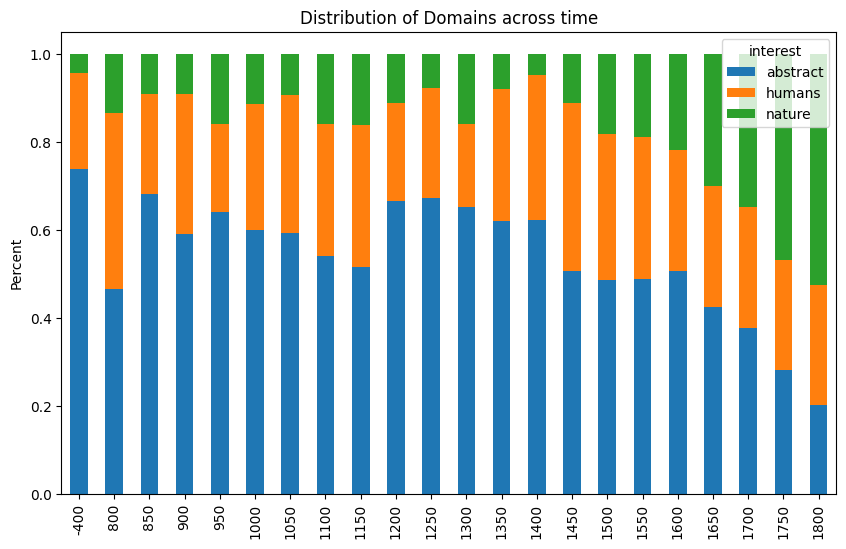

In [ ]:
data_all = pd.read_sql_query(
        "SELECT * FROM temporal_data", conn
    )

data_all = data_all[['wikidata_id', 'fifty', 'interest']].drop_duplicates().reset_index(drop=True)
data_group = data_all.groupby(['fifty', 'interest'])['wikidata_id'].count().reset_index()
data_sum = data_group.groupby('fifty')['wikidata_id'].sum().reset_index()
data_sum.columns = ['fifty', 'total']
data_sum = data_sum[data_sum['total']>=20]

df_final = pd.merge(data_group, data_sum, on = 'fifty')
df_final['percent'] = df_final['wikidata_id']/df_final['total']
df_final = df_final[df_final['fifty']<1850]

import matplotlib.pyplot as plt
import pandas as pd


# Pivot the DataFrame to get the 'interest' as columns and 'fifty' as the index
pivot_df = df_final.pivot(index='fifty', columns='interest', values='percent')

# Create a stacked bar chart
ax = pivot_df.plot(kind='bar', stacked=True, figsize=(10, 6))

# Customize the plot
plt.title('Distribution of Domains across time')
plt.xlabel('')
plt.ylabel('Percent')

# Show the plot
plt.show()

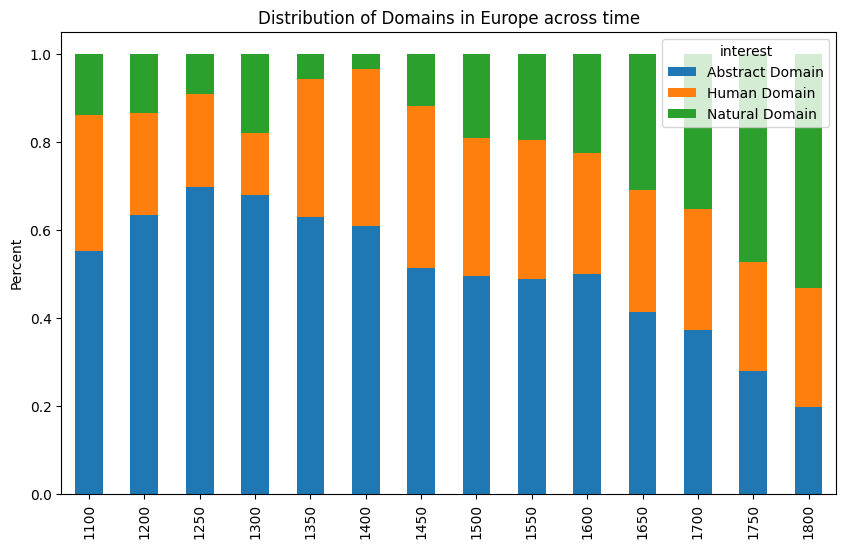

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

data_all = pd.read_sql_query(
        "SELECT * FROM temporal_data_clean", conn
    )

columns_to_keep_europe = [
        "re_central_europe",
        "re_eastern_europe",
        "re_france",
        "re_german_world",
        "re_italy",
        "re_low_countries",
        "re_nordic_countries",
        "re_slav_world",
        "re_spain",
        "re_united_kingdom",
        "re_greek_world",
    ]
data_all = data_all[data_all['region_code'].isin(columns_to_keep_europe)]

data_all = data_all[['wikidata_id', 'fifty', 'interest']].drop_duplicates().reset_index(drop=True)

data_group = data_all.groupby(['fifty', 'interest'])['wikidata_id'].count().reset_index()
data_sum = data_group.groupby('fifty')['wikidata_id'].sum().reset_index()
data_sum.columns = ['fifty', 'total']
data_sum = data_sum[data_sum['total']>=20]

df_final = pd.merge(data_group, data_sum, on = 'fifty')
df_final['percent'] = df_final['wikidata_id']/df_final['total']
df_final = df_final[df_final['fifty']<1850]

# Pivot the DataFrame to get the 'interest' as columns and 'fifty' as the index
pivot_df = df_final.pivot(index='fifty', columns='interest', values='percent')

# Create a stacked bar chart
ax = pivot_df.plot(kind='bar', stacked=True, figsize=(10, 6))

# Customize the plot
plt.title('Distribution of Domains in Europe across time')
plt.xlabel('')
plt.ylabel('Percent')

# Show the plot
plt.show()

### Non Europe

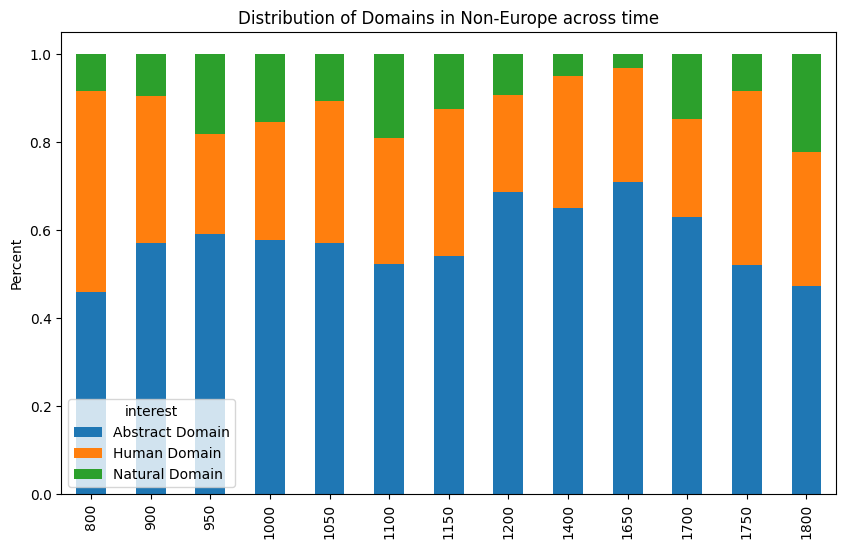

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

data_all = pd.read_sql_query(
        "SELECT * FROM temporal_data_clean", conn
    )

columns_to_keep_non_europe = [
        "re_arabic_world",
        "re_chinese_world",
        "re_indian_world",
        "re_japan",
        "re_persian_world",
    ]
data_all = data_all[data_all['region_code'].isin(columns_to_keep_non_europe)]

data_all = data_all[['wikidata_id', 'fifty', 'interest']].drop_duplicates().reset_index(drop=True)

data_group = data_all.groupby(['fifty', 'interest'])['wikidata_id'].count().reset_index()
data_sum = data_group.groupby('fifty')['wikidata_id'].sum().reset_index()
data_sum.columns = ['fifty', 'total']
data_sum = data_sum[data_sum['total']>=20]

df_final = pd.merge(data_group, data_sum, on = 'fifty')
df_final['percent'] = df_final['wikidata_id']/df_final['total']
df_final = df_final[df_final['fifty']<1850]

# Pivot the DataFrame to get the 'interest' as columns and 'fifty' as the index
pivot_df = df_final.pivot(index='fifty', columns='interest', values='percent')

# Create a stacked bar chart
ax = pivot_df.plot(kind='bar', stacked=True, figsize=(10, 6))

# Customize the plot
plt.title('Distribution of Domains in Non-Europe across time')
plt.xlabel('')
plt.ylabel('Percent')

# Show the plot
plt.show()

IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

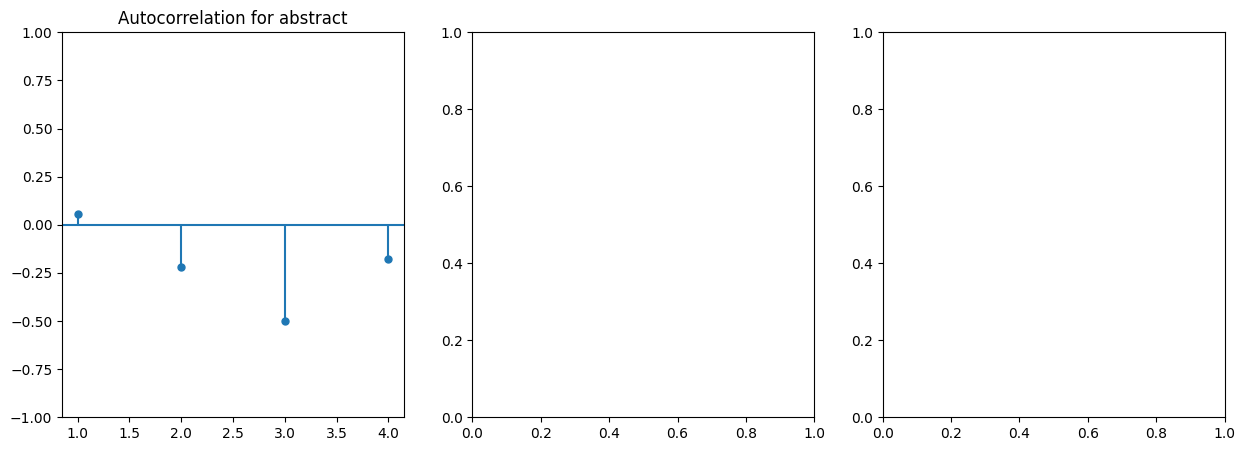

In [ ]:
# Create subplots for each variable
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Loop through each variable and plot its autocorrelation
for i, variable in enumerate(['abstract', 'nature', 'humans']):
    ax = axes[i]
    variable_data = df_final[df_final['interest'] == variable]['percent']

    plot_acf(variable_data, lags=4, ax=ax, title=f'Autocorrelation for {variable}', zero=False)

    ax.set_xlabel('Lags (every 50 years)', fontsize=12)
    ax.set_ylabel('Autocorrelation', fontsize=12)
    ax.set_title(f'Autocorrelation for {variable}', fontsize=14)

plt.tight_layout()
plt.show()

In [ ]:
df_occupation = pd.read_sql("SELECT * FROM individual_id_cleaned_occupations", conn)

df_ind_regions = pd.read_sql_query(
    "SELECT * FROM individuals_regions", conn_full_db
)
df_ind_regions = df_ind_regions.rename(
    columns={"individual_wikidata_id": "wikidata_id"}
)

df_final = pd.merge(df_occupation, df_ind_regions, on = 'wikidata_id')

columns_to_keep = [
        "re_arabic_world",
        "re_central_europe",
        "re_chinese_world",
        "re_eastern_europe",
        "re_france",
        "re_german_world",
        "re_greek_world",
        "re_indian_world",
        "re_italy",
        "re_japan",
        "re_low_countries",
        "re_nordic_countries",
        "re_persian_world",
        "re_slav_world",
        "re_spain",
        "re_united_kingdom",
    ]


df_regions = df_final[['wikidata_id', 'region_code']].drop_duplicates()
df_regions = df_regions[df_regions['region_code'].isin(columns_to_keep)]

final = []

for region in columns_to_keep:
    df_sample = df_regions[df_regions['region_code']==region]
    
    if len(df_sample) > 300:
        res = df_sample.sample(300, random_state = 42)
    else:
        res = df_sample.copy()
        
    final.append(res)
    
df_fin = pd.concat([x for x in final])

individuals_filters = list(set(df_fin['wikidata_id']))

df = df_occupation[df_occupation['wikidata_id'].isin(individuals_filters)]

In [ ]:
df_fin.groupby('region_code')['wikidata_id'].count()

region_code
re_arabic_world        201
re_central_europe      300
re_chinese_world       127
re_eastern_europe      300
re_france              300
re_german_world        300
re_greek_world         242
re_indian_world         40
re_italy               300
re_japan               136
re_low_countries       300
re_nordic_countries    300
re_persian_world        97
re_slav_world          300
re_spain               300
re_united_kingdom      300
Name: wikidata_id, dtype: int64